In [45]:
# import numpy, tensorflow and matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy
 
# import VGG 19 model and keras Model API
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [46]:

# Image Credits: Tensorflow Doc
content_path = tf.keras.utils.get_file('content.jpg',
                                       'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('style.jpg',
                                     'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [47]:
# code
# this function download the VGG model and initialise it
model = VGG19(
    include_top=False,
    weights='imagenet'
)
# set training to False
model.trainable = False
# Print details of different layers
 
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [48]:
# code to load and process image
def load_and_process_image(image_path):
    img = load_img(image_path)
    # convert image to array
    img = img_to_array(img)
    img = preprocess_input(img)

    # From tensorflow docks, regarding vgg19.preprocess_input():
    # The images are converted from RGB to BGR, then each color channel 
    # is zero-centered with respect to the ImageNet dataset, without scaling.

    img = np.expand_dims(img, axis=0)
    return img

In [49]:
# Now, we define the deprocess function that takes the input image and perform 
# the inverse of preprocess_input function that we imported above. 
# To display the unprocessed image, we also define a display function.

def deprocess(img):
    # perform the inverse of the pre processing step
    
    temp = copy.deepcopy(img)
    temp[:, :, 0] += 103.939
    temp[:, :, 1] += 116.779
    temp[:, :, 2] += 123.68
    # convert RGB to BGR
    temp = temp[:, :, ::-1]
 
    temp = np.clip(temp, 0, 255).astype('uint8')
    return temp
 
 
def display_image(image):
    # remove one dimension if image has 4 dimension
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)
 
    img = deprocess(img)
 
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

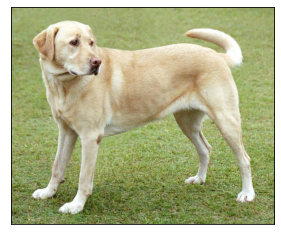

In [50]:
# load content image
content_img = load_and_process_image(content_path)
display_image(content_img)

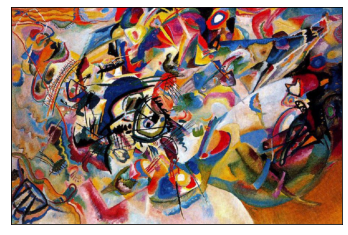

In [51]:
# load style image
style_img = load_and_process_image(style_path)
display_image(style_img)

In [52]:

# define content model
content_layer = 'block5_conv2'
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)
content_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [53]:
# define style model
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]
style_models = [Model(inputs=model.input,
                      outputs=model.get_layer(layer).output) for layer in style_layers]

In [54]:
# Content loss
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)                      # This line was missing in the tutorial.
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss

In [55]:
# gram matrix
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])       # a = (n_H * n_W, n_C)
    n = tf.shape(a)[0]                      # n = number of elements per row of a
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)    # normalise
 
 
weight_of_layer = 1. / len(style_models)
 
 
# style loss
def style_cost(style, generated):
    J_style = 0
 
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * weight_of_layer               # weight_of_layer undefined at this point
 
    return J_style

In [56]:
# training function
generated_images = []
 
def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
    # Notice that the weight for the style error is way bigger. This probably to compensate for not adding noise to initial generated image.
    
    # load content and style images from their respective path
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)
 
    opt = tf.keras.optimizers.Adam(learning_rate=1)     # learning_rate of 7 seems crazy high. Come back and change to something like 0.1
 
    best_cost = 1000000000000000             # set to a huge number (original had "Inf")
    best_image = None
    for i in range(iterations):
        #% % time
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
 
        grads = tape.gradient(J_total, generated)           # J_total is y, generated is x; 
        opt.apply_gradients([(grads, generated)])           # optimise x so as to minimise y.
 
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
 
        print("Iteration :{}".format(i))
        print('Total Loss {:e}.'.format(J_total))
        generated_images.append(generated.numpy())
 
    return best_image

The training was done on colab to use its GPU

In [57]:

# Train the model and get best image
final_img = training_loop(content_path, style_path)

Iteration :0
Total Loss 5.133926e+11.
Iteration :1
Total Loss 4.908843e+11.
Iteration :2
Total Loss 4.670722e+11.
Iteration :3
Total Loss 4.421842e+11.
Iteration :4
Total Loss 4.163988e+11.
Iteration :5
Total Loss 3.899665e+11.
Iteration :6
Total Loss 3.631357e+11.
Iteration :7
Total Loss 3.362115e+11.
Iteration :8
Total Loss 3.095671e+11.
Iteration :9
Total Loss 2.836368e+11.
Iteration :10
Total Loss 2.588567e+11.
Iteration :11
Total Loss 2.356566e+11.
Iteration :12
Total Loss 2.144744e+11.
Iteration :13
Total Loss 1.956528e+11.
Iteration :14
Total Loss 1.794055e+11.
Iteration :15
Total Loss 1.657956e+11.
Iteration :16
Total Loss 1.546954e+11.
Iteration :17
Total Loss 1.457927e+11.
Iteration :18
Total Loss 1.386363e+11.
Iteration :19
Total Loss 1.327021e+11.
Iteration :20
Total Loss 1.274799e+11.
Iteration :21
Total Loss 1.225394e+11.
Iteration :22
Total Loss 1.176009e+11.
Iteration :23
Total Loss 1.125300e+11.
Iteration :24
Total Loss 1.073176e+11.
Iteration :25
Total Loss 1.020701e+

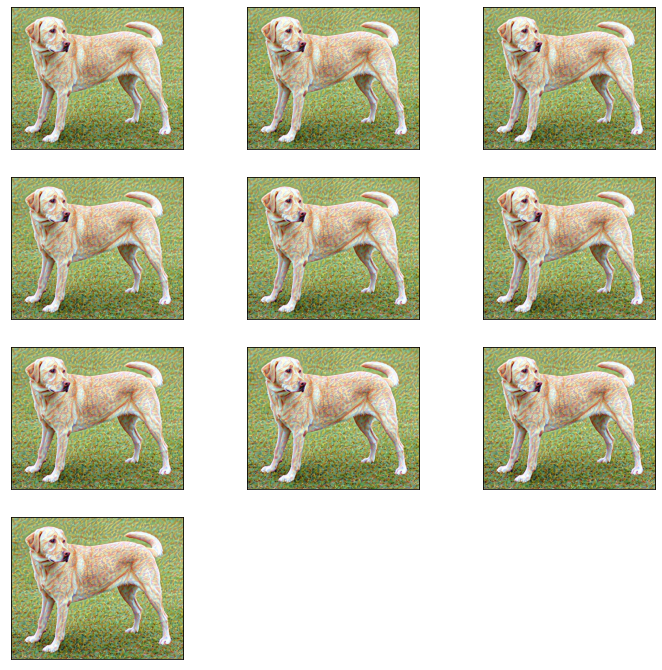

In [58]:
# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(12, 12))
 
for i in range(10):
    plt.subplot(4, 3, i + 1)
    display_image(generated_images[i+39])
plt.show()
 


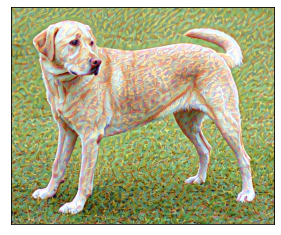

In [59]:
# plot best result
display_image(final_img)

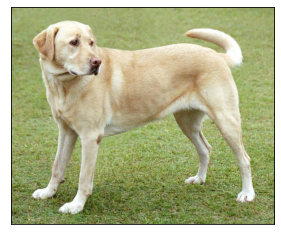

In [60]:
# plot original again:
display_image(content_img)